In [79]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import colors 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [80]:
#################### Initialize all functions ####################

sigmoid = lambda p: (((p * 20 - 10) / np.sqrt(10 + (p * 20 - 10)**2)) + 1) / 2

def scoreFunc(tdata, data):
    abs_diff = np.abs(tdata[:,0] - data[:,0])
    return abs_diff[~np.isnan(abs_diff)].mean()

# Defining SIR model differential equations
def deriv1(y, t, days, l_on, l_off, steps, a, f, polarity):
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**1.5) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(0.85 * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**1.5) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(a[0] * w)
    ])

    return dp, ds, dw


def calcLight(days, l_on, l_off, steps, t):
    # Initialize steps
    l_steps = np.linspace(l_off, l_on, steps)
    t_steps = np.linspace(0, 1, steps + 1)
    light = 0

    # If light is 99 make the light go: off => on => off
    # Distribute light in stepwise fashion otherwise
    if steps != 99:
        for i in range(len(l_steps)):
            if days * t_steps[i] <= t <= days * t_steps[i + 1]:
                light = l_steps[i]
    else:
        if days * 0.25 <= t <= days * 0.75:
            light = l_on
        else:
            light = l_off
    return light


def procData(data, title):
    # Create dataframe
    df = pd.DataFrame({
        "Potatoes": data[:, 0],
        "Nutrients": data[:, 1],
        "Worms": data[:, 2]
    })

    # Get descriptive statistics and drop unneeded info
    dfd = df.describe().drop(["25%", "50%", "75%", "count"])

    # Calculate percentage of missing values
    missings = df.isnull().sum() / 50 * 100

    # Append missing column to dataframe
    dfd = dfd.append(pd.DataFrame({"Missing (%)": missings}).T)

    # Fix labels for pretty printing later on
    dfd["Greenhouse"] = title[-1]
    dfd["Statistics"] = dfd.index
    return dfd


def perturb(pmean, pstd, data, prem):
    # Get perturbation vector
    perturb = np.random.normal(pmean, pstd, data.shape)

    # Perturb data
    data *= perturb

    # Choose certain ratio of the data by random to illustrate loss of data
    masks = np.random.choice([np.nan, 1],
                             size=(data.shape),
                             p=[prem, 1 - prem])

    # Throw away "lost" data
    data *= masks

    return data


def plotplot(ax, t, title, data, lights, td, alpha=0.7):
    # Unpack data
    data *= 10
    P, S, W = data[:, 0], data[:, 1], data[:, 2]

    if td:
        # Plot
        ax.plot(t, P, 'ob', alpha=0.7, markersize=8, label='Potatoes')
        ax.plot(t, S, 'or', alpha=0.7, markersize=8, label='Nutrients')
        ax.plot(t, W, 'og', alpha=0.7, markersize=8, label='Worms')
    else:
        # Plot simulation data
        plt.plot(t, P, 'cornflowerblue', alpha=alpha, lw=3, label='S-potatoes')
        plt.plot(t, S, 'lightcoral', alpha=alpha, lw=3, label='S-Nutrients')
        plt.plot(t, W, 'limegreen', alpha=alpha, lw=3, label='S-Worms')

    # Prettyfie that graph
    title = title + f" (Light strength={np.mean(lights)})"
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(title, fontsize=22)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(17) 
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(17) 

    # Set axis ranges; by default this will put major ticks every 25.
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlim(0, max(t))
    tmp = np.dstack((P, S, W)).flatten()
    ax.set_ylim(0, max(tmp[~np.isnan(tmp)]) * 1.1)

    # Change major ticks to show every 10.
    ax.xaxis.set_major_locator(MultipleLocator(10))

    # Change minor ticks to show every 5. (10/2 = 5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    # Turn grid on for both major and minor ticks and style minor slightly
    # differently.
    ax.grid(which='major', color='#CCCCCC', linestyle='--', lw=2, alpha=0.9)
    ax.grid(which='minor', color='#CCCCCC', linestyle=':', lw=2, alpha=0.7)
    legend = ax.legend(prop={'size': 18})
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)


def simulation(simSettings, pturb, dfunc):
    # Unpack settings
    days, l_on, l_off, steps, y0, measurements, simP, simF, simPol = simSettings
    pTrue, pmean, pstd, prem = pturb

    # Set up time and lights
    t = np.linspace(1, days, days * measurements)
    lights = [calcLight(days, l_on, l_off, steps, i) for i in t]

    # Run simulation
    data = odeint(dfunc,
                  y0,
                  t,
                  args=(days, l_on, l_off, steps, simP, simF, simPol))

    # Perturb data to simulate missing values and error
    if pTrue: perturb(pmean, pstd, data, prem)

    return t, lights, data


def interestPlots(interest,
                  dfunc,
                  figsize_x=6,
                  figsize_y=4,
                  n_columns=2,
                  pturb=(False, 1, 0.2, 9. / 10, 10)):
    # Initialize grid plot
    n_figs = len(interest)
    fig, axes = plt.subplots(nrows=int(np.ceil(n_figs / n_columns)),
                             ncols=n_columns,
                             figsize=(figsize_x * n_columns, figsize_y *
                                      int(np.ceil(n_figs / n_columns))),
                             sharey=False,
                             sharex=False)
    descriptives = []

    # Iterate through all simulations of interest
    for wI in range(len(interest)):

        # Set up axes for figure
        if n_columns > 1:
            if np.ceil(n_figs / n_columns) < 2: axs = axes[wI % n_columns]
            else: axs = axes[int(np.floor(wI / n_columns)), wI % n_columns]
        else: axs = axes

        # Some mumbo jumbo for the plot titles
        if interest[wI][3] != 99: st = interest[wI][3]
        else: st = 'off/on/off'
        title = f"Greenhouse {wI+1}"

        # Run simulation
        t, lights, data = simulation(interest[wI], pturb, dfunc)

        # Get descriptives
        descriptives.append(procData(data, title))

        # Get a single plot for the grid
        plotplot(axs, t, title, data, lights, True)

    # Save and show grid plot
    plt.tight_layout()
    plt.savefig("4farmers.png")
    plt.show()

    return lights, descriptives


def makeTable(lights, descriptives):
    # Make pretty table
    df = pd.melt(pd.concat(descriptives),
                 id_vars=['Greenhouse', 'Statistics'],
                 value_vars=['Potatoes', 'Nutrients', 'Worms'],
                 value_name='Values')
    lights = pd.DataFrame({
        "Greenhouse":
        np.linspace(1, 4, 4).astype(int).astype(str),
        "Statistics": ["" for _ in descriptives],
        "variable": ["Lights" for _ in descriptives],
        "Values":
        np.linspace(1.25, 2, len(descriptives))
    })
    df = pd.concat([lights, df], ignore_index=True)
    stats = df.set_index(['Greenhouse', 'variable',
                          'Statistics']).unstack('Greenhouse').round(2)
    display(stats)

    # Make less pretty table but with a lot less effort :)
    dscr = pd.concat(descriptives).set_index(["Greenhouse",
                                              "Statistics"]).round(2)
    display(dscr)

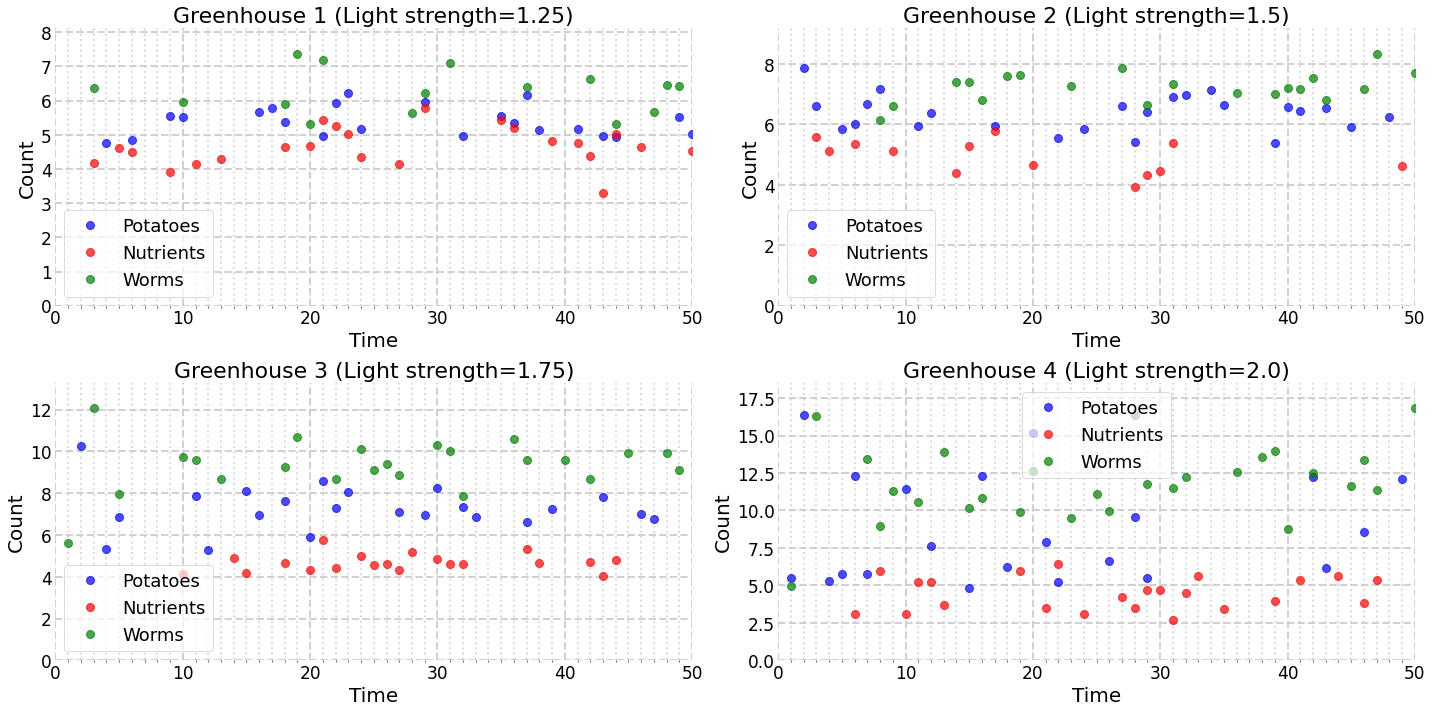

In [81]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [0.115], [sigmoid], []],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [0.12], [sigmoid], []],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [0.08], [sigmoid], []],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [0.11], [sigmoid], []],
]

pturb = [True, 1, 0.1, 6. / 10]

lights, descriptives = interestPlots(interest,
              deriv1,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

# makeTable(lights, descriptives)

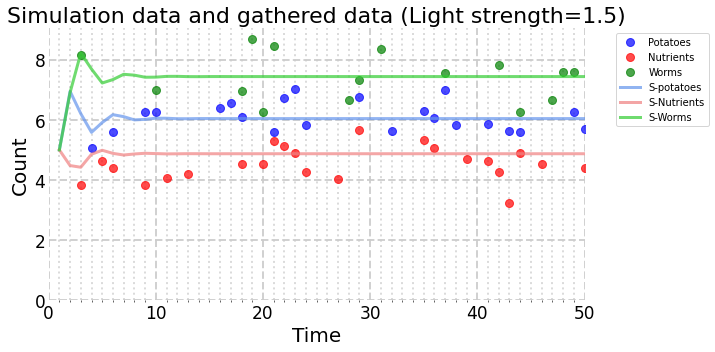

Score (MAD): 0.40821840637610546


In [82]:
# Defining SIR model differential equations
def deriv2(y, t, days, l_on, l_off, steps, a, f, polarity):
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**a[0]) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(a[1] * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**a[0]) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(0.1 * w),
        polarity[0] * (0 * f[1](w) * light)
    ])

    return dp, ds, dw


# Set axes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Set parameters
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "tmp", tdata, lights, True)

# # start simulation
a = [1.55, 0.85]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

t, lights, data = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "Simulation data and gathered data", data, lights, False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("simdata.png")
plt.show()

print(f"Score (MAD): {scoreFunc(tdata, data)}")

In [83]:
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]
dump_ratio = 3 / 9

# Get data
np.random.seed(89)
t, lights, true_data = simulation(simSettings, pturb, deriv2)

print(true_data)

nonnans = np.argwhere(~np.isnan(true_data))

index = np.arange(len(nonnans))
np.random.shuffle(index)
shuffle = nonnans[index]
print(shuffle.shape)

train = true_data.copy()
test = true_data.copy()

train_part = shuffle[:40]
test_part = shuffle[40:]

train[train_part] = np.nan
test[test_part] = np.nan
print(train)
print(test)
# # Choose certain ratio of the data by random to illustrate loss of data
# masks = np.random.choice([-1, 1],
#                          size=(true_data.shape),
#                          p=[dump_ratio, 1 - dump_ratio])

# # Throw away "lost" data
# train_data = true_data * masks
# # print(train_data)
# train = np.argwhere(train_data > 0)
# print(train[0])
# test = np.argwhere(train_data < 0)
# print(train_data[train[0][0]][[train[0][1]]])
# print(train_data[train])
# print(train_data[test])

[[       nan        nan        nan]
 [       nan        nan        nan]
 [       nan 0.38446677 0.81579459]
 [0.50638777        nan        nan]
 [       nan 0.46277391        nan]
 [0.56038664 0.44114897        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [0.62662989 0.3822019         nan]
 [0.62736946        nan 0.70066154]
 [       nan 0.40570228        nan]
 [       nan        nan        nan]
 [       nan 0.41870979        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [0.64089279        nan        nan]
 [0.65665402        nan        nan]
 [0.60899962 0.45187312 0.69658844]
 [       nan        nan 0.86896589]
 [       nan 0.45483274 0.62710371]
 [0.56110934 0.52959331 0.84549599]
 [0.67129978 0.51371698        nan]
 [0.7037369  0.49013958        nan]
 [0.58442366 0.42565213        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan 0.40448121        nan]
 [       nan        nan 0.66

In [99]:
def metro_hast(tdata, bestp, fs, polarity, pturb, N):
    # start simulation
    simSettings = [
        50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity
    ]
    t, lights, data = simulation(simSettings, pturb, deriv2)
    scores = [scoreFunc(tdata, data)]

    for i in tqdm(range(N)):
        # Perturb parameters slightly
        # newp = np.random.uniform(0.1,2,2)
        newp = np.random.normal(bestp[-1], 0.005, 2)
        simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, newp, fs, polarity]
        t, lights, data = simulation(simSettings, pturb, deriv2)
        news = scoreFunc(tdata, data)
        if news <= scores[-1]:
            scores.append(news)
            bestp.append(newp)
        else:
            random = np.random.rand()
            if random < scores[-1] / news:
                scores.append(news)
                bestp.append(newp)
    return scores, bestp


# Set parameters
bestp = [np.array([1.5, 0.85])]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)
# print(tdata)
# Run metropolis-hastings
pturb = [False, 1, 0.1, 6. / 10]
scores, bestp = metro_hast(tdata, bestp, fs, polarity, pturb, 1000)
print(scores)
# bestp = np.array(bestp)
# print(f"Scores:\n{np.array(scores)}\n\nParameters:\n{np.array(bestp)}")

100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]

[0.0410972356362681, 0.04116647783467356, 0.04111208414454325, 0.040934934831472924, 0.04079550935329193, 0.040759972183540626, 0.04070859309779846, 0.04077334527437287, 0.040986724600993535, 0.04065984425025466, 0.040899820741554065, 0.04105336080200785, 0.04108051121713441, 0.041234529673063354, 0.041140023261478455, 0.04089012100735766, 0.04076189291398571, 0.0408138217164148, 0.04084474379359195, 0.04095097684711897, 0.040944362472363154, 0.04095596595965965, 0.04082463851896986, 0.0408559496632454, 0.041222270285303904, 0.04140354890649828, 0.041590241315643366, 0.04155557849143665, 0.041566526000395336, 0.041507031067987386, 0.04157100866886683, 0.04189586685859244, 0.04169322373761563, 0.04165256731624553, 0.0416897092569682, 0.0417496565093262, 0.04186753031007735, 0.04210492767199728, 0.042343670802494314, 0.0429115459144142, 0.043034338415072336, 0.04356388911569898, 0.04384809021391137, 0.04478381974157818, 0.04441816510840407, 0.045456232095957436, 0.045229085517197204, 0.0

In [85]:
all_data = []
# draw other simulations
for a in bestp:
    simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
    pturb = [False, 1, 0.1, 6. / 10]

    t, lights, data = simulation(simSettings, pturb, deriv2)
    all_data.append(data)

In [86]:
all_data = np.array(all_data)
max0_data = [all_data[:,t][:,0].max() * 10 for t in range(len(all_data[0]))]
min0_data = [all_data[:,t][:,0].min() * 10 for t in range(len(all_data[0]))]
max1_data = [all_data[:,t][:,1].max() * 10 for t in range(len(all_data[0]))]
min1_data = [all_data[:,t][:,1].min() * 10 for t in range(len(all_data[0]))]
max2_data = [all_data[:,t][:,2].max() * 10 for t in range(len(all_data[0]))]
min2_data = [all_data[:,t][:,2].min() * 10 for t in range(len(all_data[0]))]

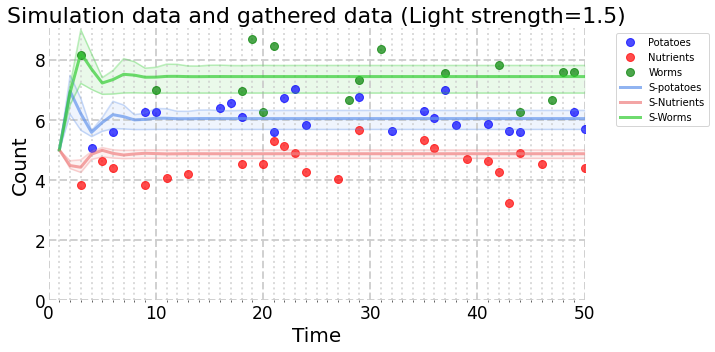

Score (MAD): 0.40821840637610546


In [87]:
# Set axes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Set parameters
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "tmp", tdata, lights, True)

# start optimal simulation
a = [1.55, 0.85]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

t, lights, data = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "Simulation data and gathered data", data, lights, False)

plt.plot(t, max0_data, 'cornflowerblue', alpha=0.3)
plt.plot(t, min0_data, 'cornflowerblue', alpha=0.3)
plt.fill_between(t, max0_data, min0_data, color='cornflowerblue', alpha=0.1)
plt.plot(t, max1_data, 'lightcoral', alpha=0.3)
plt.plot(t, min1_data, 'lightcoral', alpha=0.3)
plt.fill_between(t, max1_data, min1_data, color='lightcoral', alpha=0.1)
plt.plot(t, max2_data, 'limegreen', alpha=0.3)
plt.plot(t, min2_data, 'limegreen', alpha=0.3)
plt.fill_between(t, max2_data, min2_data, color='limegreen', alpha=0.1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("simdata.png")
plt.show()

print(f"Score (MAD): {scoreFunc(tdata, data)}")

Variance: 0.05518352538426427


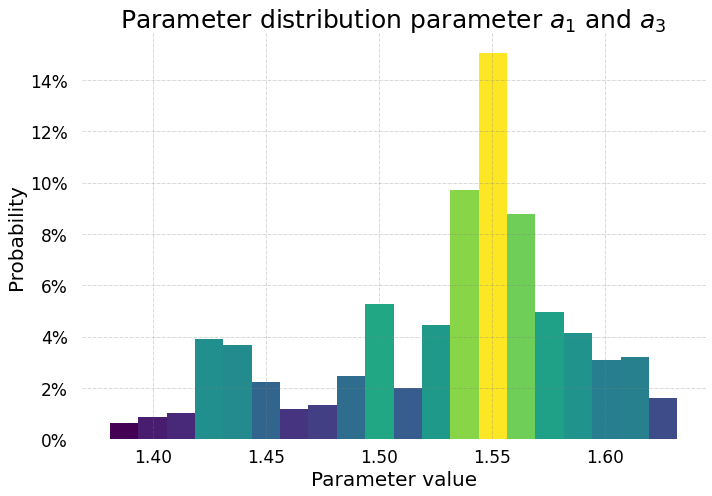

Variance: 0.04978200243391462


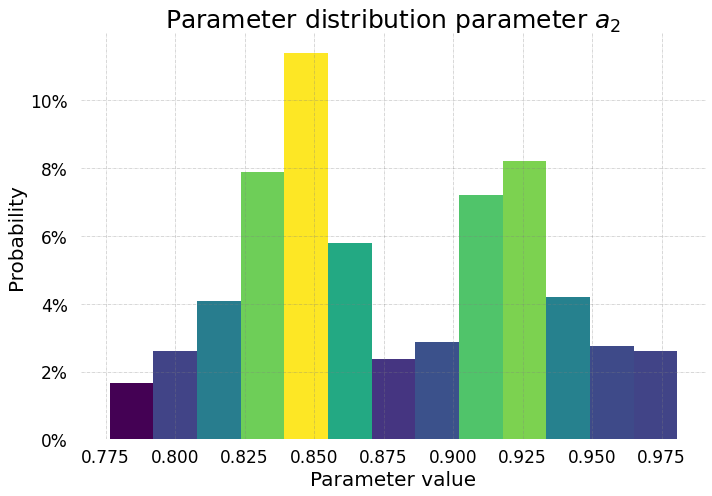

In [88]:
from matplotlib.ticker import PercentFormatter
def plotHisto(data, title, filename):
    # Creating histogram
    fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)
    N, bins, patches = axs.hist(data, bins='auto', density=True)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs.spines[s].set_visible(False)

    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    axs.xaxis.set_tick_params(pad=5)
    axs.yaxis.set_tick_params(pad=10)
    
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(17) 
        
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(17) 

    # Add x, y gridlines
    axs.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)

    # Setting color
    fracs = ((N**(1 / 5)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # Adding extra features
    plt.xlabel("Parameter value", fontsize=20)
    plt.ylabel("Probability", fontsize=20)
    axs.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    # legend = ['Distribution $a_1\ &\ a_3$']
    # plt.legend(legend)
    plt.title(title, fontsize=25)
    plt.savefig(filename)
    plt.show()


title = r'Parameter distribution parameter $a_1$ and $a_3$'
print(f"Variance: {np.std(bestp[:,0])}")
plotHisto(bestp[:, 0], title, "a1_3.png")
title = r'Parameter distribution parameter $a_2$'
print(f"Variance: {np.std(bestp[:,1])}")
plotHisto(bestp[:, 1], title, "a2.png")

In [ ]:
def metropol(y0, df, days, l_val_off, N):
    startp = [0.5, 0.5]
    tdata = odeint(df, y0, t, args=(startp[0], days, l_val_off, startp[1]))
    p = mean_absolute_error(data, tdata)

    score = [p]
    bestp = [startp]

    for i in tqdm(range(N)):
        rn = bestp[-1] + np.random.normal(0, .05, 2)
        tdata = odeint(df, y0, t, args=(startp[0], days, l_val_off, startp[1]))
        p = mean_absolute_error(data, tdata)
        if p <= score[-1]:
            score.append(p)
            bestp.append(rn)
        else:
            u = np.random.rand()
            if u < score[-1] / p:
                score.append(p)
                bestp.append(list(rn))
    return score, np.array(bestp)


def hist_plot(array):
    fig = plt.figure()
    ax = fig.add_subplot(
        1,
        1,
        1,
    )
    ax.hist(array, bins=1000)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
hist_plot(d[1][:, 0])
hist_plot(d[1][:, 1])

In [ ]:
# l_val_on = 0.3
l_val_off = 1
alpha = .5
fs = [deriv1, deriv2, deriv3]
for df in fs:
    score = 100000
    bestp = (100, 100)
    for j in range(11):
        for i in range(11):
            tdata = odeint(df, y0, t, args=(i/10, days, l_val_off, j/10))
            mae = mean_absolute_error(data, tdata)
            if mae < score: 
                score = mae
                bestp = (j/10, i/10)
                print(bestp, mae)
                
    tdata = odeint(df, y0, t, args=(bestp[1], days, l_val_off, bestp[0]))
    X, Y, Z = tdata[:, 0], tdata[:, 1], tdata[:, 2]

    # Plot the data on four separate curves
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)

    # # Plot
    ax.plot(t, X, 'b', alpha=0.5, lw=2, label='X')
    ax.plot(t, Y, 'r', alpha=0.5, lw=2, label='Y')
    ax.plot(t, Z, 'g', alpha=0.5, lw=2, label='Z')
    ax.plot(t, lights, 'k', alpha=0.5, lw=1, label='Light')

    # Prettyfie that graph
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein Expression')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    ax.set_ylim([-6, 6])
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    print("proteins_"+str(df)[10:16]+".png")
    plt.savefig("proteins_"+str(df)[10:16]+"_hillc_light.png")
    plt.show()

In [ ]:
alphas = np.linspace(0, 2, 21)
for alpha in alphas:
    data = odeint(deriv1, y0, t, args=(alpha, days, 1, 0.3))
    # data = data - np.min(data)
    # data = data / np.max(data)
    X, Y, Z = data[:, 0], data[:, 1], data[:, 2]

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)

    # # Plot SIR
    ax.plot(t, X, 'b', alpha=0.5, lw=2, label='X')
    ax.plot(t, Y, 'r', alpha=0.5, lw=2, label='Y')
    ax.plot(t, Z, 'g', alpha=0.5, lw=2, label='Z')

    # Prettyfie that graph
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein Expression')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    print(alpha)
    plt.show()